In [1]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tqdm import tqdm
import image_slicer
import random

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
gpus = tf.config.experimental.list_physical_devices('GPU')

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

print('Libraries Loaded')

Libraries Loaded


## Utilies

In [2]:
def read_imgs(path):
    img,names = [],[]
    for i in sorted(os.listdir(path)):
        names.append(i)
        imgs=cv2.imread(os.path.join(path,i))
        img.append(cv2.cvtColor(imgs, cv2.COLOR_RGB2BGR))
    return names,np.array(img)

def visualize(in_images,out_images,number):
    for i in number:
        plt.subplot(121)
        plt.imshow(in_images[i])
        plt.title('Original')
        
        plt.subplot(122)
        plt.imshow(out_images[i])
        plt.title('Output')
        
        plt.show()
    
def make_blur(img):
    # image = cv2.imread(img)
    ksize = (30, 30)
    blur = cv2.blur(img, ksize)
    return blur

def mask_blur(original_img, blur_img, predicted_img,width,height):
    # print("Shape: ", original_img.shape, blur_img.shape, predicted_img.shape)
    # cv2.imshow('img', predicted_img)
    # cv2.waitKeyEx(0)

    blue_channel_ori = original_img[:, :, 0]
    green_channel_ori = original_img[:, :, 1]
    red_channel_ori = original_img[:, :, 2]

    blue_channel_blr = blur_img[:, :, 0]
    green_channel_blr = blur_img[:, :, 1]
    red_channel_blr = blur_img[:, :, 2]

    blue_channel_pre = predicted_img[:, :, 0]
    green_channel_pre = predicted_img[:, :, 1]
    red_channel_pre = predicted_img[:, :, 2]

    new_b = []
    new_g = []
    new_r = []

    mks_img_new = np.zeros([width,height, 3])

    for i in range(3):
        if i == 0:
            img = blue_channel_blr
            msk = blue_channel_pre
            ori = blue_channel_ori
        if i == 1:
            img = green_channel_blr
            msk = green_channel_pre
            ori = green_channel_ori
        if i == 2:
            img = red_channel_blr
            msk = red_channel_pre
            ori = red_channel_ori

        if i == 0:
            new = new_b
        if i == 1:
            new = new_g
        if i == 2:
            new = new_r

        img = img.reshape(1, -1)[0]
        msk = msk.reshape(1, -1)[0]
        ori = ori.reshape(1, -1)[0]

        for k, m, o in zip(img, msk, ori):
            if int(m*255.) < 50:
                new.append(k)
            else:
                new.append(o)

        if i == 0:
            new_b = np.array(new_b).reshape(width, height)
            mks_img_new[:, :, 0] = new_b
        if i == 1:
            new_g = np.array(new_g).reshape(width, height)
            mks_img_new[:, :, 1] = new_g
        if i == 2:
            new_r = np.array(new_r).reshape(width, height)
            mks_img_new[:, :, 2] = new_r

    return mks_img_new


def create_img(original_img, predicted_img):
    blur_img = make_blur(original_img)
    img = mask_blur(original_img, blur_img, predicted_img)
    
    return img

## Main

In [3]:
## Folders
root = r'C:\Users\saad\Desktop\Image-Background-Removal\COCO Dataset\COCOdataset2017'
annotations = r'annotations'
images = r'images'
pre_imgs = r'Preprocesed_images'

## Training
train_img = 'train'
train_ann = 'instances_train.json'
train_process = 'train_images'

## Validation
val_img = r'val'
val_ann = r'instances_val.json'
val_img_process = 'val_images'
val_ann_process = 'val_ann'


In [4]:
input_name,input_images = read_imgs(os.path.join(root,pre_imgs,val_img_process))
print('Input images done')
output_name,output_images = read_imgs(os.path.join(root,pre_imgs,val_ann_process))
print('Output images done')

Input images done
Output images done


In [5]:
output_images.shape

(2090, 480, 320, 3)

In [17]:
input_processed = input_images/255.
output_processed = output_images[:,:,:,1:2]/255.
output_processed[output_processed>=0.5] = 1
output_processed[output_processed<0.5] = 0
# output_processed = output_processed.astype(np.uint8)

print(f'The shape of the input_process is {input_processed.shape} and the shape of output_processed is {output_processed.shape}')

The shape of the input_process is (2090, 480, 320, 3) and the shape of output_processed is (2090, 480, 320, 1)


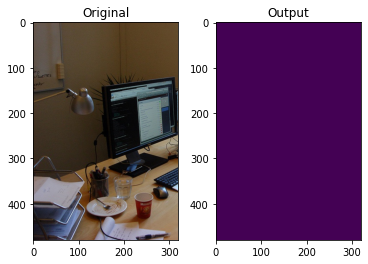

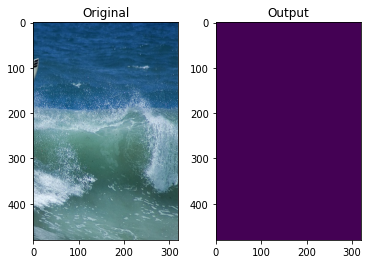

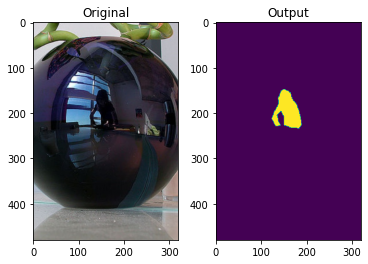

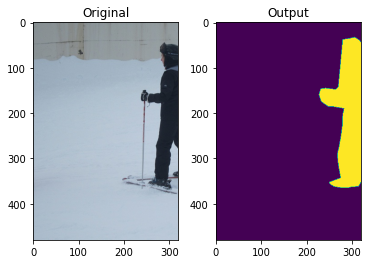

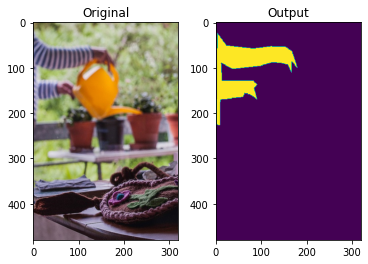

In [18]:
num = random.sample(range(0,len(input_processed)),5)
visualize(input_processed,output_processed,num)

In [19]:
x_train,x_test,y_train,y_test = train_test_split(input_processed,output_processed,test_size=0.2,random_state=42)

print(f'The shape of x_train is {x_train.shape} and the shape of y_train is {y_train.shape}')
print(f'The shape of x_test is {x_test.shape} and the shape of y_test is {y_test.shape}')

The shape of x_train is (1672, 480, 320, 3) and the shape of y_train is (1672, 480, 320, 1)
The shape of x_test is (418, 480, 320, 3) and the shape of y_test is (418, 480, 320, 1)


### Model

In [20]:
filepath = 'unet_coco.hdf5'
checkpoint =keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True)

In [ ]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

n_epochs = 1

in1 = Input(shape=(480,320, 3 ))

conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
conv1 = Dropout(0.4)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
conv2 = Dropout(0.4)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
conv3 = Dropout(0.4)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)

conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
conv4 = Dropout(0.4)(conv4)
conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
conv5 = Dropout(0.4)(conv5)
conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)

up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
conv6 = Dropout(0.4)(conv6)
conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
conv7 = Dropout(0.4)(conv7)
conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
segmentation = Conv2D(1,(1, 1),activation='sigmoid', name='seg')(conv7)

model = Model(inputs=[in1], outputs=[segmentation])

losses = {'seg': 'binary_crossentropy'
    }

metrics = {'seg': ['acc']
        }
model.compile(optimizer="adam", loss = losses, metrics=metrics)

model.summary()


# Start the training process
history = model.fit(x_train,y_train,validation_split=0.2,batch_size=1,epochs=200,callbacks=[checkpoint])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 480, 320, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 480, 320, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 480, 320, 32) 9248        dropout[0][0]                    
_______________________________________________________________________________________

Epoch 9/200
1337/1337 [==============================] - 27s 20ms/step - loss: 0.3524 - acc: 0.8561 - val_loss: 0.3188 - val_acc: 0.8741
Epoch 10/200
1337/1337 [==============================] - 27s 20ms/step - loss: 0.3598 - acc: 0.8561 - val_loss: 0.3220 - val_acc: 0.8741
Epoch 11/200
1337/1337 [==============================] - 27s 20ms/step - loss: 0.3459 - acc: 0.8561 - val_loss: 0.3161 - val_acc: 0.8741
Epoch 12/200
1337/1337 [==============================] - 27s 20ms/step - loss: 0.3475 - acc: 0.8561 - val_loss: 0.3283 - val_acc: 0.8741
Epoch 13/200
1337/1337 [==============================] - 27s 20ms/step - loss: 0.3376 - acc: 0.8561 - val_loss: 0.3234 - val_acc: 0.8741
Epoch 14/200
1337/1337 [==============================] - 27s 20ms/step - loss: 0.3361 - acc: 0.8561 - val_loss: 0.3174 - val_acc: 0.8741
Epoch 15/200
1337/1337 [==============================] - 27s 20ms/step - loss: 0.3314 - acc: 0.8561 - val_loss: 0.3086 - val_acc: 0.8741
Epoch 16/200
1337/1337 [===========

1337/1337 [==============================] - 27s 21ms/step - loss: 0.3549 - acc: 0.8591 - val_loss: 0.3399 - val_acc: 0.8744
Epoch 69/200
1337/1337 [==============================] - 27s 21ms/step - loss: 0.3558 - acc: 0.8582 - val_loss: 0.3304 - val_acc: 0.8757
Epoch 70/200
 192/1337 [===>..........................] - ETA: 21s - loss: 0.3603 - acc: 0.8534

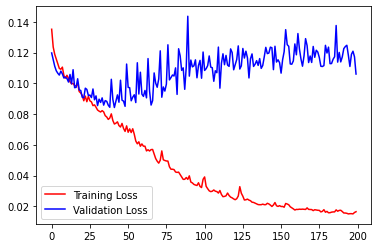

In [12]:
plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

In [16]:
model.load_weights(filepath)
predictions = model.predict(x_test)
predictions.shape

(209, 224, 224, 3)

In [14]:
predictions

array([[[[1.21177603e-02, 2.49216948e-02, 1.35617033e-02],
         [8.81910045e-03, 1.01167457e-02, 6.56264508e-03],
         [4.21654526e-03, 6.70935214e-03, 4.00114479e-03],
         ...,
         [4.57617680e-05, 9.90252593e-05, 2.66590723e-05],
         [4.96784050e-04, 6.87525433e-04, 2.08512371e-04],
         [2.45905272e-03, 2.60951696e-03, 1.05806987e-03]],

        [[1.35871284e-02, 1.77388173e-02, 1.40416073e-02],
         [1.44618331e-02, 1.40814111e-02, 1.40808094e-02],
         [9.65478458e-03, 8.68170895e-03, 1.02929100e-02],
         ...,
         [3.72888928e-04, 3.69527959e-04, 4.08857508e-04],
         [1.70433207e-03, 9.43409803e-04, 9.87267937e-04],
         [1.46722386e-03, 1.40459149e-03, 1.41257700e-03]],

        [[1.01787522e-02, 1.33058149e-02, 1.07496912e-02],
         [1.36203747e-02, 1.41636087e-02, 1.21024093e-02],
         [1.01906452e-02, 9.66756418e-03, 9.75738559e-03],
         ...,
         [5.71646029e-04, 5.35985397e-04, 4.77611320e-04],
         [

In [95]:
p=np.expand_dims(np.argmax(predictions,axis=-1),axis=-1)

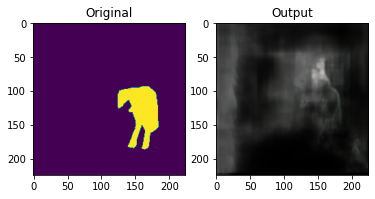

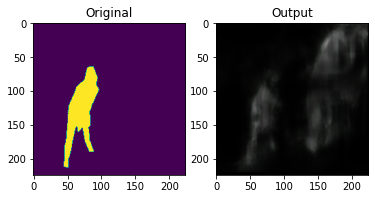

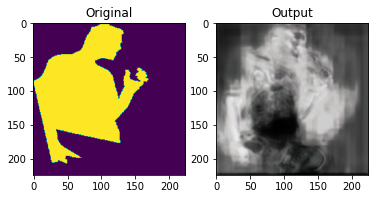

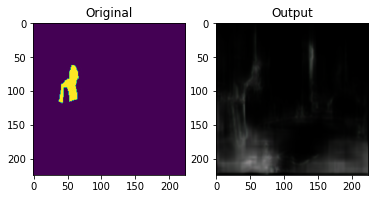

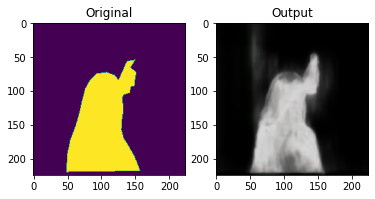

In [17]:
visualize(y_test[:,:,:,:1],predictions,[1,2,3,4,5])

In [28]:
x=np.copy(predictions[0])
# x[x>=0.5]=1
# x[x<0.5]=0
x.shape

(224, 224, 3)

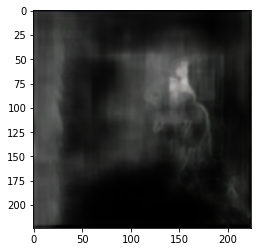

In [25]:
plt.imshow(x)

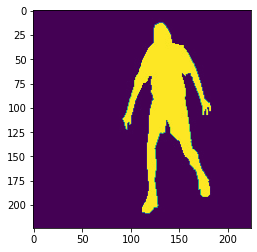

In [20]:
plt.imshow(y_test[6,:,:,:1])

In [118]:
b = np.dstack([x]*3)
b.shape

(224, 224, 3)

In [29]:
foo=create_img(x_test[0],x)

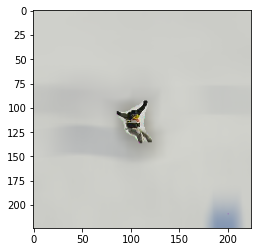

In [30]:
plt.imshow(foo)

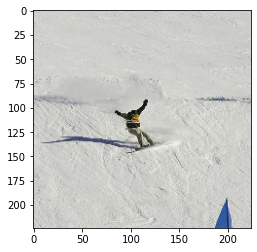

In [31]:
plt.imshow(x_test[0])

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [40]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


def unet(num_classes, input_shape, lr_init, lr_decay, vgg_weight_path=None):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu',name='before_VGG')(x)

    for_pretrained_weight = MaxPooling2D()(x)

    # Load pretrained weights.
    if vgg_weight_path is not None:
        print('VGG entered')
        vgg16 = Model(img_input, for_pretrained_weight)
        vgg16.load_weights(vgg_weight_path, by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # last conv
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(lr=lr_init, decay=lr_decay),
                  loss='mse',
                  metrics=[dice_coef,'accuracy'])
    return model

In [41]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
model = unet(3,(224,224,3),1e-4,5e-4,'vgg_weights.h5')
model.summary()

VGG entered
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 64) 0           batch_normalization[0][0]        
___________________________________________________________________________

In [42]:
filepath1 = 'unet_coco1.hdf5'
checkpoint1 =keras.callbacks.ModelCheckpoint(filepath1, monitor='val_loss', verbose=0, save_best_only=True)
history1 = model.fit(x_train,y_train,validation_split=0.2,batch_size=16,epochs=5,callbacks=[checkpoint1])

Epoch 1/5
42/42 [==============================] - 14s 326ms/step - loss: 0.1724 - dice_coef: 0.1968 - accuracy: 0.3332 - val_loss: 0.2703 - val_dice_coef: 0.1945 - val_accuracy: 0.8108
Epoch 2/5
42/42 [==============================] - 13s 313ms/step - loss: 0.1598 - dice_coef: 0.1951 - accuracy: 0.3418 - val_loss: 0.1583 - val_dice_coef: 0.1945 - val_accuracy: 0.6798
Epoch 3/5
42/42 [==============================] - 12s 296ms/step - loss: 0.1590 - dice_coef: 0.1968 - accuracy: 0.3375 - val_loss: 0.1599 - val_dice_coef: 0.1945 - val_accuracy: 0.5474
Epoch 4/5
42/42 [==============================] - 13s 314ms/step - loss: 0.1589 - dice_coef: 0.1966 - accuracy: 0.3326 - val_loss: 0.1563 - val_dice_coef: 0.1945 - val_accuracy: 0.5180
Epoch 5/5
42/42 [==============================] - 13s 313ms/step - loss: 0.1587 - dice_coef: 0.1964 - accuracy: 0.3362 - val_loss: 0.1562 - val_dice_coef: 0.1945 - val_accuracy: 0.5080


In [43]:
preds = model.predict(x_test)
preds.shape

(209, 224, 224, 3)

In [44]:
x = np.copy(preds[0])
# x[x>=0.5]=1
# x[x<0.5]=0
np.unique(x)

array([0.24427441, 0.24874222, 0.25347617, ..., 0.43861714, 0.4421156 ,
       0.44770852], dtype=float32)

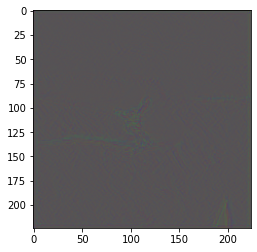

In [45]:
plt.imshow(x)

In [ ]:
plt.imsho